In [ ]:
import sys

In [ ]:
!nvidia-smi

In [ ]:
!pip3 install --upgrade --user google-cloud-aiplatform

In [ ]:
!pip install "unstructured[all-docs]" 

In [ ]:
!pip install langchain

In [ ]:
!pip install langchain-community

In [ ]:
!pip install langchain_google_vertexai

In [ ]:
!pip install pillow-heif

In [ ]:
!pip install unstructured_inference

In [ ]:
!pip install matplotlib

In [ ]:
!pip install tiktoken

In [ ]:
!pip install pytesseract
!pip install tesseract-ocr

In [1]:
pdf_folder_path = "/home/sridhanya_ganapathi_team_neustar/rag/data/image"
pdf_file_name = "/home/sridhanya_ganapathi_team_neustar/rag/data/contract_agreement.pdf"
Pdf_title="contract_agreement.pdf"


In [2]:
import sys
from langchain_community.document_loaders import PyPDFLoader

from google.cloud import aiplatform

import base64
import os
import uuid
import re

from typing import List, Tuple

from IPython.display import display, Image, Markdown

from langchain.prompts import PromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

from langchain_community.vectorstores import Chroma

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_text_splitters import CharacterTextSplitter

from langchain_google_vertexai import (
    VertexAI,
    ChatVertexAI,
    VertexAIEmbeddings,
    VectorSearchVectorStore,
)

from unstructured.partition.pdf import partition_pdf


In [3]:
PROJECT_ID = "edl-idaas-rnd-platform-d5ae"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

print(f"Your project ID is: {PROJECT_ID}")
# For Vector Search Staging
GCS_BUCKET = "sridhanya"  # @param {type:"string"}
GCS_BUCKET_URI = f"gs://{GCS_BUCKET}"

Your project ID is: edl-idaas-rnd-platform-d5ae


In [4]:
aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=GCS_BUCKET_URI)

In [5]:
image_pdf_folder_path = "/home/sridhanya_ganapathi_team_neustar/rag/images"
pdf_file_name = "/home/sridhanya_ganapathi_team_neustar/rag/data/contract_agreement.pdf"

# Extract images, tables, and chunk text from a PDF file.
raw_pdf_elements = partition_pdf(
    filename=pdf_file_name,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=pdf_folder_path,
    extract_image_block_types=["Image", "Table"],
    extract_image_block_output_dir=image_pdf_folder_path,
    extract_image_block_to_payload=False
)

# Categorize extracted elements from a PDF into tables and texts.
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=10000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

2024-08-05 11:51:52.201508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 11:51:52.412749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 11:51:52.473905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 11:51:52.933165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at microsoft/tab

In [6]:
len(texts)

5

In [7]:
MODEL_NAME = "gemini-1.0-pro-vision"


# Generate summaries of text elements
def generate_text_summaries(
    texts: List[str], tables: List[str], summarize_texts: bool = False
) -> Tuple[List, List]:
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = VertexAI(
        temperature=0, model_name=MODEL_NAME, max_output_tokens=1024
    ).with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts:
        if summarize_texts:
            text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
        else:
            text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [8]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

    msg = model(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval.
    If it's a table, extract all elements of the table.
    If it's a graph, explain the findings in the graph.
    Do not include any numbers that are not mentioned in the image.
    """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(image_pdf_folder_path)

/opt/conda/envs/llm/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [10]:
len(image_summaries)

7

## Create & Deploy Vertex AI Vector Search Index & Endpoint

https://console.cloud.google.com/vertex-ai/matching-engine/indexes 
https://cloud.google.com/vertex-ai/docs/vector-search/create-manage-index

### Create MatchingEngineIndex

In [17]:
DIMENSIONS = 768  # Dimensions output from textembedding-gecko
DEPLOYED_INDEX = "contract_agreement_rag_langchain_index"
DEPLOYED_ENDPOINT = "contract_agreement_rag_langchain_index_endpoint"
DEPLOYED_INDEX_ENDPOINT_ID = "contract_agreement_rag_langchain_deployed_index"
index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DEPLOYED_INDEX,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description="contract_agreement_en Multimodal RAG LangChain Index",
)

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/199599498795/locations/us-central1/indexes/8493872460104466432/operations/2747521399936516096
MatchingEngineIndex created. Resource name: projects/199599498795/locations/us-central1/indexes/8493872460104466432
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/199599498795/locations/us-central1/indexes/8493872460104466432')


### Create MatchingEngineIndexEndpoint

In [18]:


index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DEPLOYED_ENDPOINT,
    description="contract_agreement_en Multimodal RAG LangChain Index Endpoint",
    public_endpoint_enabled=True,
)

Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208/operations/5406052554968662016
MatchingEngineIndexEndpoint created. Resource name: projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208')


### Deploy Index to Index Endpoint
https://console.cloud.google.com/vertex-ai/matching-engine/indexes

In [19]:
index_endpoint = index_endpoint.deploy_index(
    index=index, deployed_index_id=DEPLOYED_INDEX_ENDPOINT_ID
)
index_endpoint.deployed_indexes

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208/operations/3069528773293506560
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/199599498795/locations/us-central1/indexEndpoints/8227104550926942208


[id: "contract_agreement_rag_langchain_deployed_index"
index: "projects/199599498795/locations/us-central1/indexes/8493872460104466432"
create_time {
  seconds: 1722859428
  nanos: 67340000
}
index_sync_time {
  seconds: 1722860975
  nanos: 6336000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

### Create retriever & load documents

In [20]:
# The vectorstore to use to index the summaries
vectorstore = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=LOCATION,
    gcs_bucket_name=GCS_BUCKET,
    index_id=index.name,
    endpoint_id=index_endpoint.name,
    embedding=VertexAIEmbeddings(model_name="textembedding-gecko@002"),
)


In [21]:
docstore = InMemoryStore()

id_key = "doc_id"
# Create the multi-vector retriever
retriever_multi_vector_img = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

In [22]:
doc_contents = texts + tables + img_base64_list

In [23]:
doc_ids = [str(uuid.uuid4()) for _ in doc_contents]

In [24]:
# remove empty content
image_summaries2=[]
import re
for i in range(0,len(image_summaries)):
    if (image_summaries[i] != ''):
        image_summaries2.append(image_summaries[i])

In [25]:
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries + table_summaries + image_summaries2)
]

In [26]:
retriever_multi_vector_img.docstore.mset(list(zip(doc_ids, doc_contents)))

In [ ]:
# If using Vertex AI Vector Search, this will take a while to complete.
# You can cancel this cell and continue later.
retriever_multi_vector_img.vectorstore.add_documents(summary_docs)

Updating MatchingEngineIndex index: projects/199599498795/locations/us-central1/indexes/8493872460104466432
Update MatchingEngineIndex index backing LRO: projects/199599498795/locations/us-central1/indexes/8493872460104466432/operations/1838920175114518528


### Create Chain with Retriever and Gemini LLM


In [32]:
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = [
        {
            "type": "text",
            "text": (
                "You are financial analyst tasking with providing investment advice.\n"
                "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
                "Use this information to provide investment advice related to the user's question. \n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    ]

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            messages.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return [HumanMessage(content=messages)]


# Create RAG chain
chain_multimodal_rag = (
    {
        "context": retriever_multi_vector_img | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | ChatVertexAI(
        temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
    )  # Multi-modal LLM
    | StrOutputParser()
)

In [33]:
query = """
 - Who originally signed this contract?
 - What is the effective date of the contract?
 - Who is the address of the client?
"""

['A] iE P.O. Box 1749 Halifax, Nova Scotia REGIONAL MUNICIPALITY B3J 3A5 Canada\n\nHalifax Regional Council August 6, 2013\n\nItem No. 14.1\n\nTO:         Mayor Savage and Members of Halifax Regional Council                  SUBMITTED BY:  ___________________________________________________________                                       Richard Butts, Chief Administrative Officer         __________________________________________________________  Mike Labrecque, Deputy Chief Administrative Officer      DATE:      July 31, 2013      SUBJECT:   Non-Disclosure Agreement with the Province of Nova Scotia   \n\n  \n\n     \n\nORIGIN\n\nOn June 25, 2013, Regional Council authorized the CAO to negotiate and execute an agreement for SAP support services with the Province of Nova Scotia.\n\nLEGISLATIVE AUTHORITY\n\nUnder section 58(5) of the HRM Charter, Regional Council has the power to make and carry out a contract. Under section 10(3) of the HRM Charter, the Mayor and Clerk may sign any docume

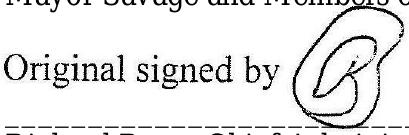

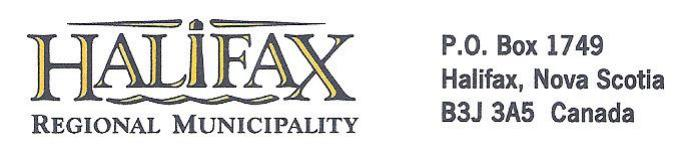

In [36]:
# List of source documents
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=10)

source_docs = split_image_text_types(docs)

print(source_docs["texts"])

for i in source_docs["images"]:
    display(Image(base64.b64decode(i)))

In [37]:
chain_multimodal_rag.invoke(query)

' - The contract was originally signed by Mayor Savage and the Members of Halifax Regional Council.\n\n\n- The effective date of the contract is August 6, 2013.\n\n\n- The address of the client is P.O. Box 1749 Halifax, Nova Scotia B3J 3A5 Canada.'

### Cleanup of resources


from google.cloud import aiplatform

# List all indexes
indexes = aiplatform.MatchingEngineIndex.list()

# List all endpoints
endpoints = aiplatform.MatchingEngineIndexEndpoint.list()

# Extract and list the names of the indexes and endpoints
index_names = [index.display_name for index in indexes]
endpoint_names = [endpoint.display_name for endpoint in endpoints]


# Print the names of the indexes and endpoints
print("Index Names:")
print(index_names)
print("\nEndpoint Names:")
print(endpoint_names)

# Delete all indexes
for index in indexes:
    index.delete()

# Delete all endpoints
for endpoint in endpoints:
    endpoint.delete()